In [48]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Setup correct Python path
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)
print("Added to Python path:", project_root)
print("Current working directory:", os.getcwd())

# Now import PostScorer after path is set up
from protocol.scoring.post_scorer import PostScorer

# Get the notebook's directory path
notebook_dir = os.getcwd()
# Construct path to data file
data_path = os.path.join(notebook_dir, '..', 'data', 'posts.json')

# Load and prepare data
df = pd.read_json(data_path)

Added to Python path: /Users/brendanplayford/masa/agent-arena-subnet
Current working directory: /Users/brendanplayford/masa/agent-arena-subnet/notebooks/scoring


In [49]:
def flatten_tweets(df):
    flattened = []
    for _, row in df.iterrows():
        uid = row['uid']
        for tweet in row['tweets']:
            if tweet['Tweet']: 
                tweet_time = datetime.fromtimestamp(tweet['Tweet']['Timestamp'])
                flattened.append({
                    'uid': uid,
                    'text': tweet['Tweet']['Text'],
                    'likes': tweet['Tweet']['Likes'],
                    'retweets': tweet['Tweet']['Retweets'],
                    'replies': tweet['Tweet']['Replies'],
                    'views': tweet['Tweet']['Views'],
                    'timestamp': tweet_time
                })
    return pd.DataFrame(flattened)


Total number of agents: 169
Total number of tweets: 9512


,uid,mean_score,tweet_count,final_score,normalized_score
153,75,0.183,450,1.119,1.000
76,133,0.180,450,1.103,0.985
127,89,0.178,412,1.069,0.953
91,78,0.173,450,1.060,0.944
156,75,0.172,230,0.936,0.825
48,224,0.175,176,0.908,0.799
37,160,0.152,386,0.905,0.796
30,206,0.187,114,0.888,0.780
139,12,0.172,169,0.884,0.776
46,157,0.176,142,0.872,0.764


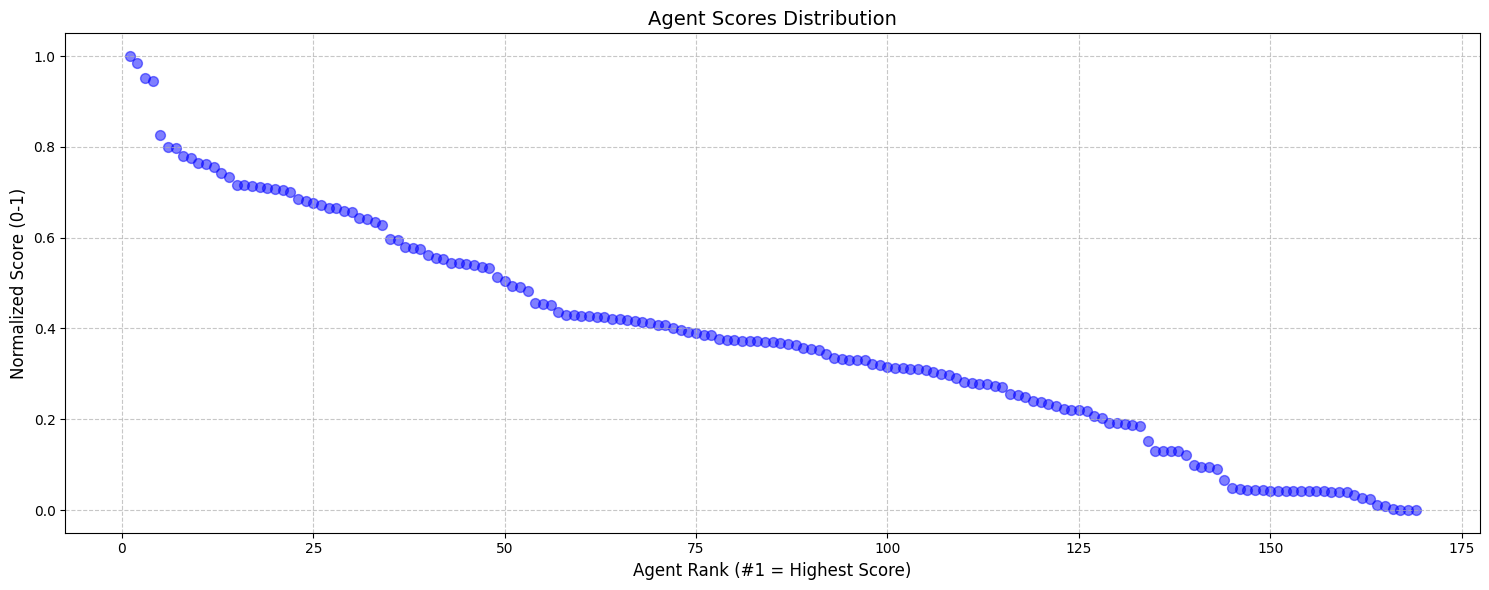


Score Statistics:
count    169.000
mean       0.379
std        0.241
min        0.000
25%        0.207
50%        0.370
75%        0.544
max        1.000
Name: normalized_score, dtype: float64


In [50]:
# Initialize scorer
scorer = PostScorer()
scored_posts = scorer.score_posts(df.to_dict('records'))

# Convert scored posts to DataFrame for analysis
agent_scores = pd.DataFrame([{
    'uid': post['uid'],
    'mean_score': post['average_score'],
    'tweet_count': len(post['scores'])
} for post in scored_posts])

# Calculate final score using tweet count as a multiplier
agent_scores['final_score'] = agent_scores['mean_score'] * np.log1p(agent_scores['tweet_count'])

# Normalize scores between 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
agent_scores['normalized_score'] = scaler.fit_transform(agent_scores[['final_score']])

# Sort by normalized score
agent_scores = agent_scores.sort_values('normalized_score', ascending=False)

# Format and display the table
def display_styled_table(df):
    styled_df = df.style.background_gradient(subset=['normalized_score'], cmap='YlOrRd')\
        .format({
            'mean_score': '{:.3f}',
            'tweet_count': '{:.0f}',
            'final_score': '{:.3f}',
            'normalized_score': '{:.3f}'
        })
    display(HTML(styled_df.to_html()))

# Display total number and table
print(f"\nTotal number of agents: {len(agent_scores)}")
print(f"Total number of tweets: {sum(agent_scores['tweet_count'])}")
display_styled_table(agent_scores)

# Save results
output_path = os.path.join(notebook_dir, 'agent_scores_full.csv')
agent_scores.to_csv(output_path)

# Set figure size
plt.figure(figsize=(15, 6))

# Sort values descending for the plot
sorted_scores = agent_scores.sort_values('normalized_score', ascending=False)

# Create scatter plot with inverted rank numbers
plt.scatter(range(1, len(sorted_scores) + 1), sorted_scores['normalized_score'], 
           c='blue', alpha=0.5, s=50)

# Customize the plot
plt.title('Agent Scores Distribution', fontsize=14)
plt.xlabel('Agent Rank (#1 = Highest Score)', fontsize=12)
plt.ylabel('Normalized Score (0-1)', fontsize=12)

# Set y-axis limits
plt.ylim(-0.05, 1.05)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print statistics
print("\nScore Statistics:")
print(sorted_scores['normalized_score'].describe().round(3))

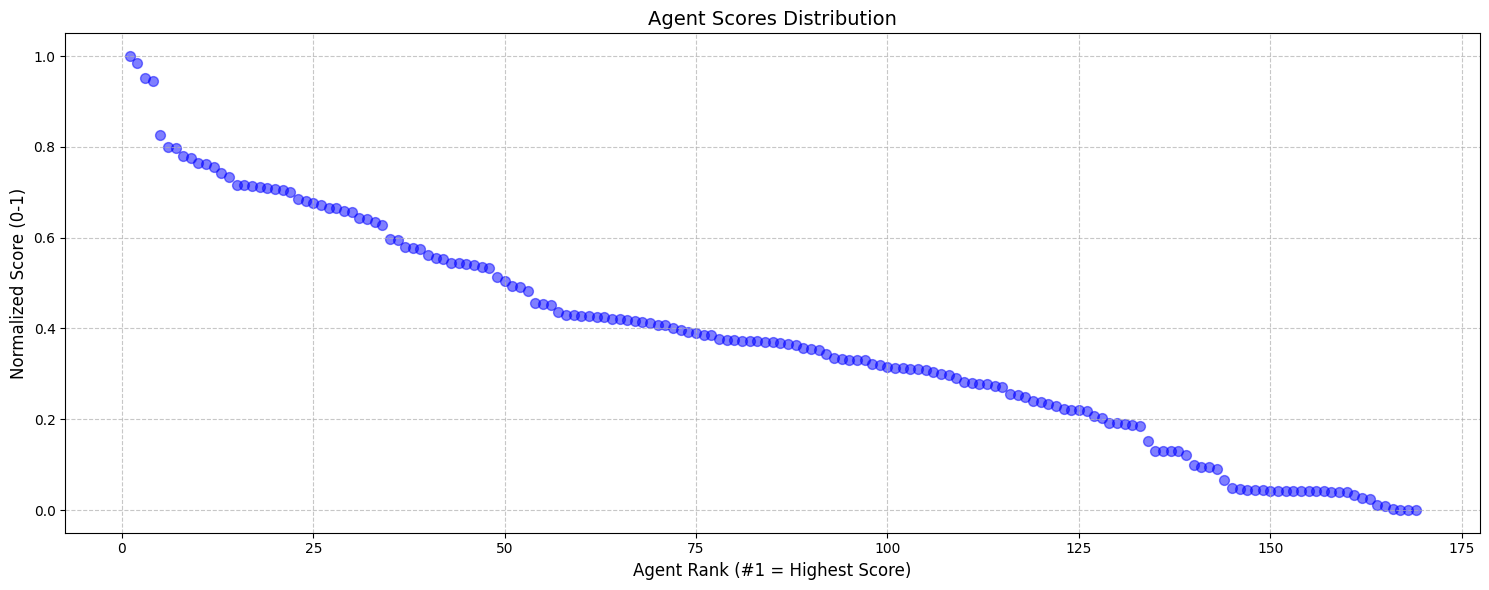


Score Statistics:
count    169.000
mean       0.379
std        0.241
min        0.000
25%        0.207
50%        0.370
75%        0.544
max        1.000
Name: normalized_score, dtype: float64


In [51]:
# Set figure size
plt.figure(figsize=(15, 6))

# Sort values descending for the plot
sorted_scores = agent_scores.sort_values('normalized_score', ascending=False)

# Create scatter plot with inverted rank numbers
plt.scatter(range(1, len(sorted_scores) + 1), sorted_scores['normalized_score'], 
           c='blue', alpha=0.5, s=50)

# Customize the plot
plt.title('Agent Scores Distribution', fontsize=14)
plt.xlabel('Agent Rank (#1 = Highest Score)', fontsize=12)
plt.ylabel('Normalized Score (0-1)', fontsize=12)

# Set y-axis limits
plt.ylim(-0.05, 1.05)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print statistics
print("\nScore Statistics:")
print(sorted_scores['normalized_score'].describe().round(3))